<a href="https://colab.research.google.com/github/RhezzouneOumaima/road-detection/blob/main/project_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detection et reconnaissance des panneaux routiers
Réalisé par: 


*   RHEZZOUNE Oumaima





DATASET utilisé GTSRB se compose de 43 classes de panneaux de signalisation et de près de 50 000 images.
 Il contient 4 fichiers :


*   signnames.csv – Il contient toutes les étiquettes et leurs descripteurs.
*   train.p - Il contient toutes les intensités de pixels de l'image d'entraînement ainsi que les étiquettes.
*   valid.p - Il contient toutes les intensités de pixel de l'image de validation ainsi que les étiquettes.
*   test.p - Il contient toutes les intensités de pixel de l'image de test ainsi que les étiquettes.
Les fichiers .p sont appelés fichiers pickle, qui sont utilisés pour sérialiser des objets en flux de caractères. Ceux-ci peuvent être désérialisés et réutilisés ultérieurement en les chargeant à l'aide de la bibliothèque pickle en python
C'est  la manipulation des données utilise un fichier par sérialisation, où les données sont stockées sous forme de chaînes.


In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
Unpacking objects: 100% (6/6), done.


In [ ]:
import tensorflow as tf
import numpy as np#pour les calculs numériques
import matplotlib.pyplot as plt
import keras#pour construire rapidement le réseau de neurones convolutifs avec moins de code
import pickle#pour les données de dataset
import pandas as pd#pour importer et gérer l'ensemble de données
import random
import cv2#pour effectuer certaines étapes de prétraitement nécessaires à l'extraction efficace des caractéristiques des images par le CNN
import requests

from skimage import io, color, exposure, transform
from PIL import Image
from keras.models import Sequential, Model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
np.random.seed(0)

# **Chargement de données**
Maintenant le temps de chargement des données. Nous utiliserons pandas pour charger signnames.csv et pickle pour charger les fichiers de train, de validation et de test pickle. Après extraction des données, celles-ci sont ensuite découpées à l'aide des libellés du dictionnaire "features" et "labels".

In [ ]:
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)
#on a des données sous forme d'un dictionnaire

print(type(train_data))
# Extraire les étiquettes(labels) des dictionnaires

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

<class 'dict'>


In [ ]:
# afficher la forme
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [ ]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"

assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"
assert(X_val.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"

# Afficher des exemples des images pour chaque classes

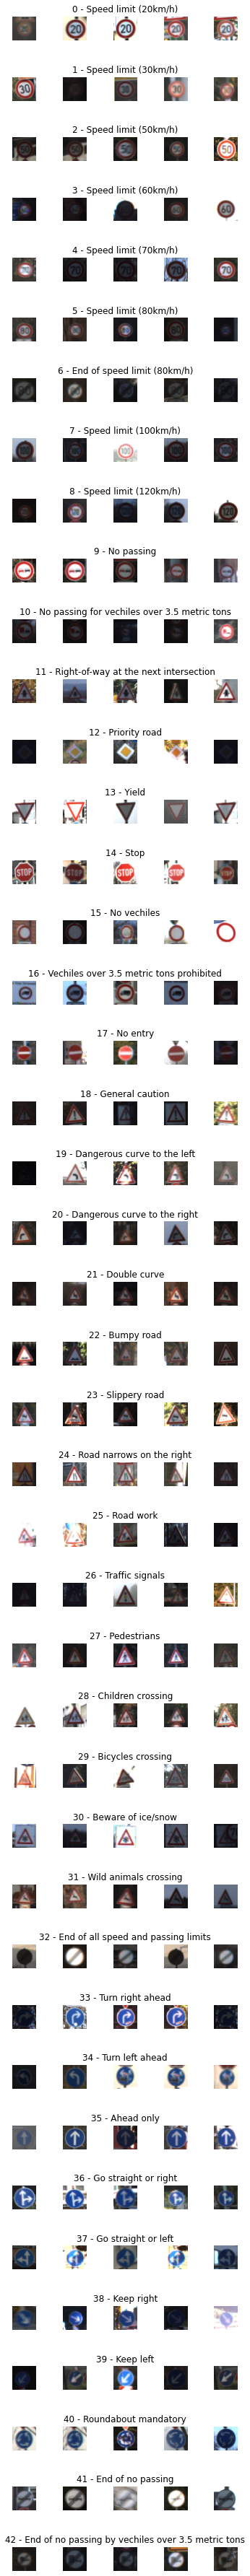

In [ ]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
          
num_of_samples=[]
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
 
for i in range(cols):
      for j, row in data.iterrows():
        x_selected = X_train[y_train == j]#selectionner les images appartient a une étiquette
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))#pour chaque class afficher des images aléatoires
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + " - " + row["SignName"])
            num_of_samples.append(len(x_selected))

# Afficher un graph pour indiquer le nombre d'échantillons pour chaque catégorie

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


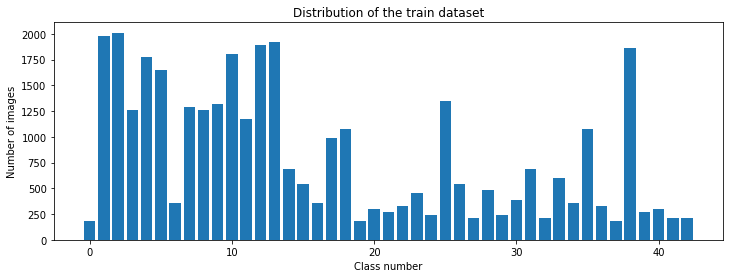

In [ ]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

# Tester en utilisant une image de training (image avec son étiquette)

(32, 32, 3)
36


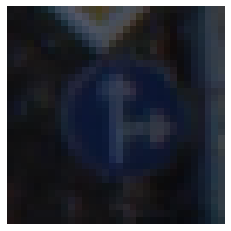

In [ ]:
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])


# prétraitement des images 
avant de les alimenter dans le modèle donne des résultats très précis car il aide à extraire les caractéristiques complexes de l'image. OpenCV a des fonctions intégrées comme cvtColor() et equalizeHist() pour cette tâche. Suivez les étapes ci-dessous pour cette tâche -

Tout d'abord, les images sont converties en images en niveaux de gris pour réduire le calcul à l'aide de la fonction cvtColor() .
La fonction equalizeHist() augmente les contrastes de l'image en égalisant les intensités des pixels en les normalisant avec leurs pixels proches.
A la fin, nous normalisons les valeurs des pixels entre 0 et 1 en les divisant par 255.

(32, 32)


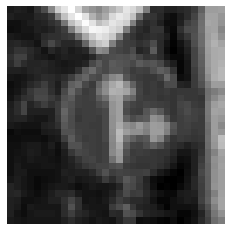

In [ ]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

img = grayscale(X_train[1000])
plt.imshow(img, cmap="gray")
plt.axis("off")
print(img.shape)

(32, 32)


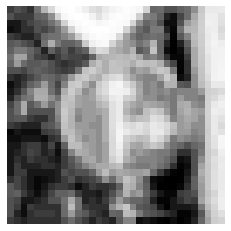

In [ ]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

img = equalize(img)
plt.imshow(img, cmap="gray")
plt.axis("off")
print(img.shape)

(34799, 32, 32, 3)


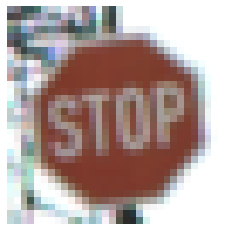

In [ ]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)], cmap='gray')
plt.axis('off')
print(X_train.shape)


In [ ]:
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

X_train = np.array(list(map(preprocessing, X_train)))
X_test = np.array(list(map(preprocessing, X_test)))
X_val = np.array(list(map(preprocessing, X_val)))

In [ ]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_val= X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

# Préparation des données
Il est temps de les intégrer au modèle pour la formation. Mais pour augmenter la précision de notre modèle CNN, nous allons impliquer une étape supplémentaire de génération d'images augmentées à l'aide de ImageDataGenerator.

Nous convertissons également les étiquettes en valeurs catégorielles, comme nous le faisons normalement.

(15, 32, 32, 1)


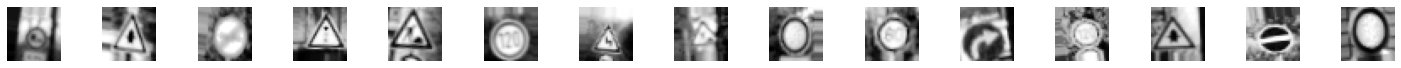

In [ ]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                                height_shift_range=0.1,
                                zoom_range=0.2,
                                shear_range=0.1,
                                rotation_range=10.)
     
datagen.fit(X_train)

    # for X_batch, y_batch in
     

batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)
     
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
     
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32), cmap="gray")
    axs[i].axis("off")
     
print(X_batch.shape)

In [ ]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

# Construire le modèle
Comme nous avons 43 classes d'images, nous définissons num_classes sur 43. Le modèle contient deux couches Conv2D suivies d'une couche MaxPooling2D. Ceci est fait deux fois pour l'extraction efficace des caractéristiques, qui est suivie par les couches denses. Une couche d'abandon de 0,5 est ajoutée pour éviter de surajuster les données.

In [ ]:
    # create model
     
def modified_model():
        model = Sequential()
        model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
        model.add(Conv2D(60, (5, 5), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
      
        model.add(Conv2D(30, (3, 3), activation='relu'))
        model.add(Conv2D(30, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
      
        model.add(Flatten())
        model.add(Dense(500, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(43, activation='softmax'))
      
        model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
        return model

In [ ]:
model = modified_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#history = model.fit(datagen.flow(X_train, y_train, batch_size=50),
                           # steps_per_epoch=2000,
                            #epochs=8,
                            #validation_data=(X_val, y_val), shuffle = 1)
history = model.fit(X_train,y_train,epochs=10,batch_size=400,verbose=1,shuffle=1,validation_data=(X_val,y_val))

Epoch 1/10
87/87 [==============================] - 15s 44ms/step - loss: 1.9282 - accuracy: 0.4794 - val_loss: 0.5017 - val_accuracy: 0.8735
Epoch 2/10
87/87 [==============================] - 2s 28ms/step - loss: 0.4028 - accuracy: 0.8763 - val_loss: 0.2545 - val_accuracy: 0.9277
Epoch 3/10
87/87 [==============================] - 2s 28ms/step - loss: 0.2045 - accuracy: 0.9403 - val_loss: 0.1960 - val_accuracy: 0.9415
Epoch 4/10
87/87 [==============================] - 2s 28ms/step - loss: 0.1225 - accuracy: 0.9631 - val_loss: 0.1629 - val_accuracy: 0.9542
Epoch 5/10
87/87 [==============================] - 2s 28ms/step - loss: 0.0929 - accuracy: 0.9713 - val_loss: 0.1671 - val_accuracy: 0.9551
Epoch 6/10
87/87 [==============================] - 2s 28ms/step - loss: 0.0722 - accuracy: 0.9777 - val_loss: 0.1366 - val_accuracy: 0.9615
Epoch 7/10
87/87 [==============================] - 2s 28ms/step - loss: 0.0558 - accuracy: 0.9823 - val_loss: 0.1338 - val_accuracy: 0.9637
Epoch 8/10
8

# Tracé de la fonction de perte.

Text(0.5, 0, 'epoch')

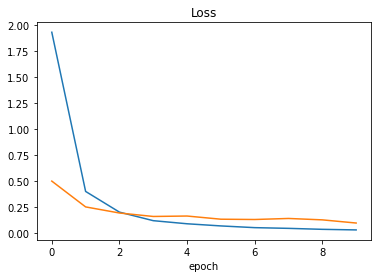

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

# Tracer la fonction de précision.

Text(0.5, 0, 'epoch')

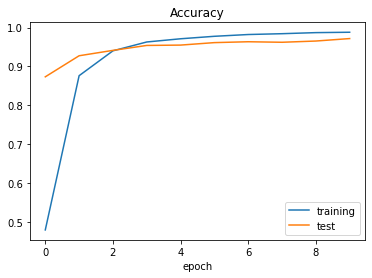

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')

# Evaluation de modèle

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
    
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.23536939918994904
Test accuracy: 0.9437846541404724


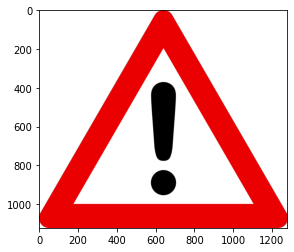

In [ ]:
url = 'https://cdn.pixabay.com/photo/2012/04/23/15/39/traffic-sign-38589_1280.png'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


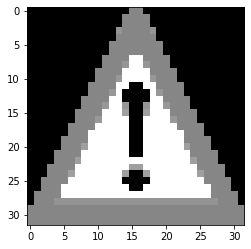

In [ ]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
#img = equalize(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)

In [ ]:
predict_x=model.predict(img) 
classes_x=np.argmax(predict_x,axis=1)
print("predicted sign: "+ str(classes_x))

predicted sign: [18]


# Partie de Detection

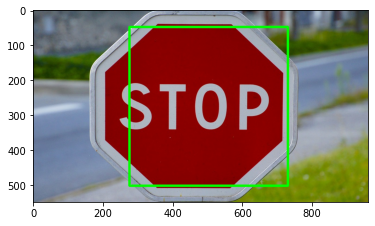

In [ ]:
import cv2 
from matplotlib import pyplot as plt 
  
# ouvrir image 
img = cv2.imread("gg.jpg") 
  


# cv2.cvtColor()La méthode est utilisée pour convertir une image d'un espace colorimétrique à un autre.
# Il existe plus de 150 méthodes de conversion d'espace colorimétrique disponibles dans OpenCV
#COLOR_BGR2GRAY:color space 
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 



# CascadeClassifier: basés sur des fonctionnalités de Haar,
 #basée sur l'apprentissage automatique où un la fonction cascade est formée à partir d'un grand nombre d'images positives et négatives.
stop_data = cv2.CascadeClassifier('stop_data.xml')  
  

  #detectMultiScale: Détecte des objets de différentes tailles dans l'image d'entrée. 
  #Les objets détectés sont renvoyés sous la forme d'une liste de rectangles
found = stop_data.detectMultiScale(img_gray,  
                                   minSize =(20, 20)) 
  

amount_found = len(found) 
  
if amount_found != 0: 
      
    # There may be more than one 
    # sign in the image 
    for (x, y, width, height) in found: 
          
        # We draw a green rectangle around 
        # every recognized sign 
        cv2.rectangle(img_rgb, (x, y),  
                      (x + height, y + width),  
                      (0, 255, 0), 5) 
          
# Creates the environment of  
# the picture and shows it 
plt.subplot(1, 1, 1) 
plt.imshow(img_rgb) 
plt.show() 

(32, 32)


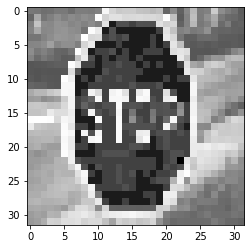

In [ ]:
img = np.asarray(img_rgb)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
#img = equalize(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)

In [ ]:
predict_x=model.predict(img) 
classes_x=np.argmax(predict_x,axis=1)
print("predicted sign: "+ str(classes_x))

predicted sign: [14]
